#### Configuración

In [3]:
## Celda de configuración

# Librerias
from IPython.display import Image, display
import math
import time
import sys
import os

# Instancias y algoritmos
sys.path.append(os.path.abspath("../Instances"))
from InsTSP import (
    generar_datos,       # Genera coordenadas geográficas de nodos (clientes)
    distancias_tsp,      # Calcula matriz de distancias entre nodos
    reconstruir_tour,    # Reconstruye la ruta óptima desde solución de TSP
    visualizar,          # Visualiza el recorrido en coordenadas geográficas
    hacer_gif            # Volver las imagenes a GIF
)

# Algoritmos de ruteo
sys.path.append(os.path.abspath("../Ruteo"))
from Lazy_TSP import optimizar_tcl_lazy
from Heuristicas import tsp_nn, tsp_cheapest_insertion, tsp_2opt_atsp, tour_cost



In [4]:
import glob
import os

for f in glob.glob("Assets/MIP/*.png"):
    os.remove(f)

for f in glob.glob("Assets/MIP/*.gif"):
    os.remove(f)

for f in glob.glob("Assets/NN/*.png"):
    os.remove(f)

for f in glob.glob("Assets/NN/*.gif"):
    os.remove(f)

for f in glob.glob("Assets/CI/*.png"):
    os.remove(f)

for f in glob.glob("Assets/CI/*.gif"):
    os.remove(f)

for f in glob.glob("Assets/2OPT_NN/*.png"):
    os.remove(f)

for f in glob.glob("Assets/2OPT_NN/*.gif"):
    os.remove(f)

for f in glob.glob("Assets/2OPT_CI/*.png"):
    os.remove(f)

for f in glob.glob("Assets/2OPT_CI/*.gif"):
    os.remove(f)

In [5]:
def contar_subconjuntos(N: list) -> int:
    return sum(math.comb(len(N), r) for r in range(2, len(N)))

# LuzLuna

Luz de Luna es una pequeña empresa con sede en Bogotá, especializada en la elaboración y distribución de cosméticos naturales hechos a base de ingredientes orgánicos, como aceites esenciales, manteca de karité y extractos botánicos.

Para expandir su presencia en el mercado nacional, la empresa realiza envíos de muestras de productos (como cremas, aceites y exfoliantes) a sus clientes mayoristas ubicados en distintos lugares del país.

La empresa cuenta con una avioneta que parte del almacén central en Bogotá. Esta furgoneta debe:

1. Visitar a n clientes, cada uno en un lugar diferente del país.
2. Hacer una única visita por cliente para entregar las muestras.
3. Regresar al almacén una vez finalizado el recorrido.

El objetivo es minimizar la distancia recorrida.



---

El **Problema del Viajante** (*Traveling Salesperson Problem*, TSP) consiste en encontrar un recorrido de costo mínimo que visite **exactamente una vez** cada ciudad (o punto) de un conjunto dado y **regrese al punto de partida**. El “costo” puede representar distancia, tiempo, dinero u otra medida asociada a viajar entre pares de ciudades.

In [6]:
# ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

# . Número de clinetes a visitar.
NUM_CLIENTES = 12

# . Generar datos.
clientes = generar_datos(NUM_CLIENTES)
distancias = distancias_tsp(clientes, modo='long')

visualizar(clientes)

# . Guardar resultados.
resultados = []

## Optimización (MIP)

### Primeras Intuiciones

Suponemos un conjunto de ubicaciones formado por una **bodega (nodo 0)** y **n clientes** numerados $1,\dots,n$. Para cada par ordenado de nodos distintos $(i,j)$ se conoce un costo $c_{ij} \ge 0$ (p. ej., distancia). El objetivo es encontrar un tour cerrado de costo mínimo que salga de la bodega, visite **exactamente una vez** cada cliente y regrese al origen.

##### 1. Conjuntos
- $N = \{0,1,2,\dots,n\}$: nodos (0 = bodega).
- $A = \{(i,j) : i,j \in N,\ i \ne j\}$: arcos dirigidos en el grafo completo.

##### 2. Parámetros
- $c_{ij}$: costo de viajar de $i$ a $j$, para todo $(i,j) \in A$ (distancia, tiempo, etc.).


##### 3. Variables de decisión
$$
x_{ij} =
\begin{cases}
1 & \text{si el tour usa el arco }(i,j),\\
0 & \text{en otro caso,}
\end{cases}
\qquad (i,j) \in N.
$$

##### 4. Función objetivo
$$
\min \sum_{(i,j) \in N} c_{ij}\, x_{ij}.
$$

##### 5. Restricciones

-  5.1 Salida única de cada nodo
$$
\sum_{j \in N,\ j \ne i} x_{ij} = 1 \qquad \forall i \in N.
$$

-  5.2 Entrada única a cada nodo
$$
\sum_{j \in N,\ j \ne i} x_{ji} = 1 \qquad \forall i \in N.
$$

- 5.3 Naturaleza de las variables
$$
x_{ij} \in \{0,1\} \qquad \forall (i,j) \in A.
$$

In [7]:
# 1. TODO Extraiga los parámetros relevantes desde el DataFrame

# Conjunto de nodos (IDs únicos)
N = list(clientes['ID'])  # incluye bodega y clientes

# Diccionario de distancias entre nodos (formato: A[(i, j)] = distancia_km)
A = {(i, j): float(d) for i, j, d in distancias[['Origen', 'Destino', 'Dist_km']].itertuples(index=False)}

# ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

# Agrega la dirección inversa (j, i) si no está definida y i ≠ j.
A.update({(j, i): d for (i, j), d in A.items() if (j, i) not in A and i != j})

In [8]:
# 2. TODO Complete la siguiente función

import pulp as lp

def optimizar_tsp(N, A):

    # Definir el problema.
    model = lp.LpProblem("TSP", lp.LpMinimize)

    # Variables de decisión
    x = {(i, j): lp.LpVariable(f"x_{i}_{j}", cat=lp.LpBinary) for i in N for j in N if i != j}

    # Función Objetivo
    model += lp.lpSum(x[i, j] * A[i, j] for i, j in x)

    # Restricciones
    # ▸ Una única salida por nodo
    for i in N:
        model += lp.lpSum(x[i, j] for j in N if i != j) == 1

    # ▸ Una única entrada por nodo
    for i in N:
        model += lp.lpSum(x[j, i] for j in N if i != j) == 1

    # ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

    # Resolver
    solver = lp.PULP_CBC_CMD(msg=False)
    model.solve(solver)

    # Reportar
    print(f'El optimizador llegó a una solución: {lp.LpStatus[model.status]}.')
    return model, x


In [9]:
# ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

# . Correr el optimizador.
model, x = optimizar_tsp(N, A)

# . Reporte
print("Distancia mínima total:", round(lp.value(model.objective), 2))

# . Visualizar
sel_arcos = [(i, j) for (i, j) in x if lp.value(x[(i, j)]) == 1]
visualizar(clientes, sel_arcos)

El optimizador llegó a una solución: Optimal.
Distancia mínima total: 1986.16


### Modelo Clásico

**¿Es correcto el resultado?**

##### 5. Restricciones

-  5.1 Salida única de cada nodo
$$
\sum_{j \in N,\ j \ne i} x_{ij} = 1 \qquad \forall i \in N.
$$

-  5.2 Entrada única a cada nodo
$$
\sum_{j \in N,\ j \ne i} x_{ji} = 1 \qquad \forall i \in N.
$$

> Las restricciones 5.1 y 5.2 anteriores aseguran grado 1 de salida y entrada en cada nodo, pero todavía permiten la aparición de subtours disjuntos; se requiere una restricción para forzar un único tour que cubra a todos los nodos.

- 5.3 Restricción de eliminación de subtours

$$
\sum_{i \in S} \sum_{j \in S,\ j \ne i} x_{ij} \le |S| - 1
\qquad \forall S \subset N,\ 2 \le |S| \le n.
$$

Esta desigualdad impide que los nodos de cualquier subconjunto propio $S$ formen por sí solos un ciclo completo (lo que requeriría $|S|$ arcos internos).

In [10]:
# ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

import itertools

def optimizar_tsp_clasico(N, A, solver, report = False):

    # Definir el problema.
    model = lp.LpProblem("TSP_Lazy", lp.LpMinimize)

    # Variables de decisión
    x = {(i, j): lp.LpVariable(f"x_{i}_{j}", cat=lp.LpBinary) for i in N for j in N if i != j}

    # Función Objetivo
    model += lp.lpSum(x[i, j] * A[i, j] for i, j in x)

    # Restricciones
    # ▸ Una única salida por nodo
    for i in N:
        model += lp.lpSum(x[i, j] for j in N if i != j) == 1, f"Salida_{i}"

    # ▸ Una única entrada por nodo
    for i in N:
        model += lp.lpSum(x[j, i] for j in N if i != j) == 1, f"Entrada_{i}"

    # ------------------------------------------------------------------------
    # RESTRICCIONES DE SUBTOURS (combinaciones de subconjuntos)
    # ------------------------------------------------------------------------
    # ▸ Se eliminan ciclos menores a |N| con: ∑_{i,j ∈ S, i≠j} x[i,j] ≤ |S| - 1
    # ▸ Esto crece exponencialmente → solo viable para tamaños pequeños

    S_list = [tuple(S) for r in range(2, len(N)) for S in itertools.combinations(N, r)]

    for _, S in enumerate(S_list):
        model += lp.lpSum(x[i, j] for i in S for j in S if i != j) <= len(S) - 1
    
    # ------------------------------------------------------------------------

    # Resolver
    model.solve(solver)

    # Reportar
    if report: print(f'El optimizador llegó a una solución: {lp.LpStatus[model.status]}.')
    return model, x

In [11]:
# ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

# . Correr el optimizador.
solver = lp.getSolver('PULP_CBC_CMD', msg = False)
model, x = optimizar_tsp_clasico(N, A, solver, report = True)

# . Reporte
print("Distancia mínima total:", round(lp.value(model.objective), 2))

# . Visualizar
sel_arcos = [(i, j) for (i, j) in x if lp.value(x[(i, j)]) == 1]
visualizar(clientes, sel_arcos)

El optimizador llegó a una solución: Optimal.
Distancia mínima total: 3583.36


#### Viabilidad

La formulación clásica expuesta tiene un problema: el modelo crece en tamaño muy rapido a medida que aumenta la cantidad de clientes.

In [12]:
# 3. TODO Define la cantidad de clientes a usar. Pruebe varios número
NUM_CLIENTES = 25

# ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

clientes = range(2, NUM_CLIENTES)
subtoures = [contar_subconjuntos(list(range(i))) for i in clientes]

import plotly.graph_objects as go

# Crear la figura
fig = go.Figure()

# --- Subtours ---
fig.add_trace(go.Scatter(
    x=list(clientes),
    y=subtoures,
    mode='markers+lines',
    marker=dict(size=8, color='blue'),
    line=dict(width=2, color='blue'),
    name='Subtours',
))

# --- Configuración de diseño con doble eje ---
fig.update_layout(
    title="# Clientes vs # Subtoures a invalidar",
    xaxis=dict(title="Número de clientes"),
    yaxis=dict(
        title="Número de subconjuntos",
        showgrid=False
    ),
    plot_bgcolor="white"
)

fig.show()


El problema radica en la:

**Restricciones de subtours (combinaciones de subconjuntos)**

* *Se eliminan ciclos menores a |N|* con:

  $$
  \sum_{i,j \in S, \, i \neq j} x_{i,j} \leq |S| - 1
  $$

* *Complejidad:* Crece exponencialmente, como se ve en la gráfica (tanto para subtoures a invalidar, como el tiempo que tardaria en explorarlos).

Entonces, *¿cómo se puede resolver una instacia grande con optimización?*

### Modelo Lazy

Formulamos un modelo de TSP clásico (basado en flujo binario), pero **sin** incluir restricciones de subtour desde el inicio. Se resuelve el problema con solo las restricciones de grado (entrada/salida), y añadimos lazy constraints para elininar subtoures.

In [13]:
# 4. TODO Defina una cantidad de clientes cerca a 200.
NUM_CLIENTES = 200

# ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

# . Generar datos.
clientes = generar_datos(NUM_CLIENTES)
distancias = distancias_tsp(clientes, modo='long')
visualizar(clientes, nombre_archivo="MIP/0")

# . Parámetros
N = list(clientes['ID'])
A = {(i, j): float(d) for i, j, d in distancias[['Origen', 'Destino', 'Dist_km']].itertuples(index=False)}
A.update({(j, i): d for (i, j), d in A.items() if (j, i) not in A and i != j})

In [14]:
# ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.
model, x, sols_mip, times_mip, valido_mip = optimizar_tcl_lazy(clientes, N,A)

# . Reporte
print("Distancia mínima total (MIP):", round(lp.value(model.objective), 2))

# . Visualizar
sel_arcos = [(i, j) for (i, j) in x if lp.value(x[(i, j)]) == 1]
tour = reconstruir_tour(sel_arcos, N)
visualizar(clientes, sel_arcos, nombre_archivo="MIP/1001")

resultados.append({
    "Método"    : "LP",
    "Distancia" : round(lp.value(model.objective), 2),
    "Tiempo (s)": times_mip[-1]
})

Se invalidaron 94 subtours --> Time solver: 2.567 seg.
Se invalidaron 30 subtours --> Time solver: 3.278 seg.
Se invalidaron 18 subtours --> Time solver: 4.21 seg.
Se invalidaron 15 subtours --> Time solver: 5.738 seg.
Se invalidaron 7 subtours --> Time solver: 4.109 seg.
Se invalidaron 6 subtours --> Time solver: 6.429 seg.
Se invalidaron 4 subtours --> Time solver: 7.558 seg.
Se invalidaron 5 subtours --> Time solver: 8.112 seg.
Se invalidaron 2 subtours --> Time solver: 10.473 seg.
Se invalidaron 2 subtours --> Time solver: 9.799 seg.
Se invalidaron 3 subtours --> Time solver: 16.569 seg.
Se invalidaron 2 subtours --> Time solver: 18.441 seg.
Se invalidaron 3 subtours --> Time solver: 12.124 seg.
Tour válido encontrado en iteración 14.

Distancia mínima total (MIP): 11773.89


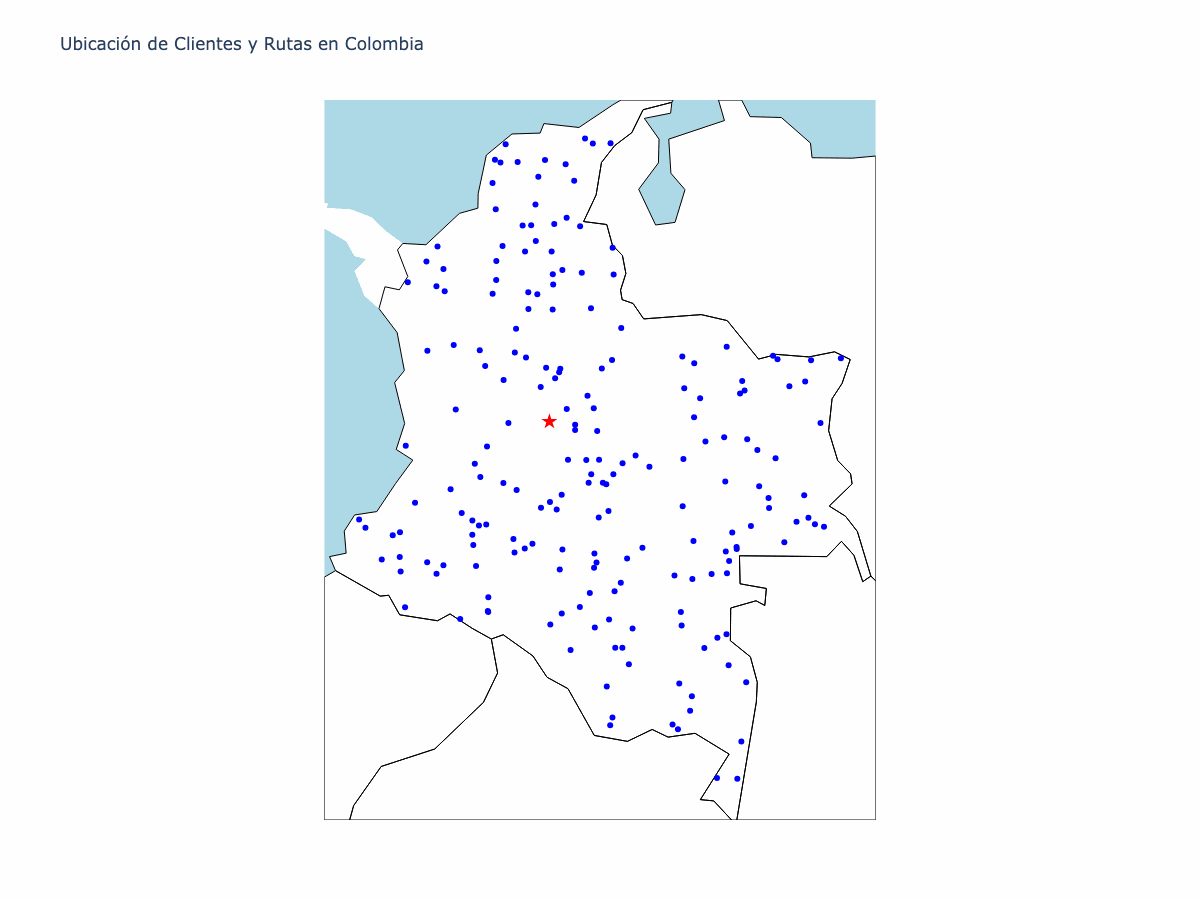

In [15]:
# ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

# . Mostrar la evolución de Optimizador
hacer_gif("Assets/MIP/*.png", "Assets/MIP/tour_lazy_tsp.gif", ms_por_frame=600)
display(Image(filename='Assets/MIP/tour_lazy_tsp.gif'))

## Heuristicas

| **Heurística**                                      | **¿Qué hace? (explicación sencilla)**                                                                                                                                   | **Pasos básicos (visión “receta”)**                                                                                                                                                                                                                                                                                                                                                   |
| --------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Vecino más cercano (NN, ATSP)**                   | Parte de un nodo (p.ej. “Bodega”) y siempre va al cliente no visitado más cercano según el costo $A[(i,j)]$. Construye un tour rápido pero miope.                       | 1. Elige nodo inicial $start$.<br>2. Marca todos los demás como “no visitados”.<br>3. Desde el nodo actual, escoge el no visitado con menor costo de viaje.<br>4. Añádelo al tour y márcalo como visitado.<br>5. Repite hasta visitar todos.<br>6. Cierra el ciclo regresando a $start$.                                                                                              |
| **Inserción más barata (Cheapest Insertion, ATSP)** | Empieza con un ciclo pequeño y va insertando, uno por uno, los nodos que menos aumenten el costo total. Busca el “hueco” más barato para cada nuevo nodo.               | 1. Define $start$. Elige otro nodo “barato” desde $start$ y forma ciclo inicial de 2 nodos.<br>2. Lista de nodos aún no insertados.<br>3. Para cada nodo candidato y cada posición posible, calcula el incremento $\Delta$ costo.<br>4. Inserta el nodo/posición con $\Delta$ mínimo.<br>5. Actualiza costos/tiempos y repite hasta insertar todos.<br>6. Cierra el tour con $start$. |
| **Mejora local 2‑opt (dirigido, ATSP)**             | Toma un tour existente y trata de mejorarlo invirtiendo subrutas. Cambia dos arcos por otros dos; si baja el costo, acepta el cambio. Repite hasta que no haya mejoras. | 1. Parte de un tour inicial (p.ej. NN o CI).<br>2. Recorre pares de arcos $(i\!\to\!a)$ y $(b\!\to\!j)$.<br>3. Propón reemplazo por $(i\!\to\!b)$ y $(a\!\to\!j)$, invirtiendo el segmento $[a\ldots b]$.<br>4. Si el nuevo costo es menor, adopta el cambio y reinicia la búsqueda.<br>5. Continúa hasta que no haya mejoras posibles.<br>6. Devuelve el mejor tour encontrado.      |

<br>

> Lo que se demora en estás celdas es la creación de las imagenes para enteder cada uno de los pasos. No obstante, por dentro de cada método el tiempo de contabiliza de manera adecuada.

### NN

In [16]:
# ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

tour_nn, sols_nn, times_nn, valido_nn = tsp_nn(clientes, N, A, start=N[0])
print("Distancia total (NN):", round(tour_cost(tour_nn, A), 2))

visualizar(clientes, tour_nn, nombre_archivo="NN/1001")

resultados.append({
    "Método"    : "NN",
    "Distancia" : round(tour_cost(tour_nn, A), 2),
    "Tiempo (s)": times_nn[-1]
})

Distancia total (NN): 14552.66


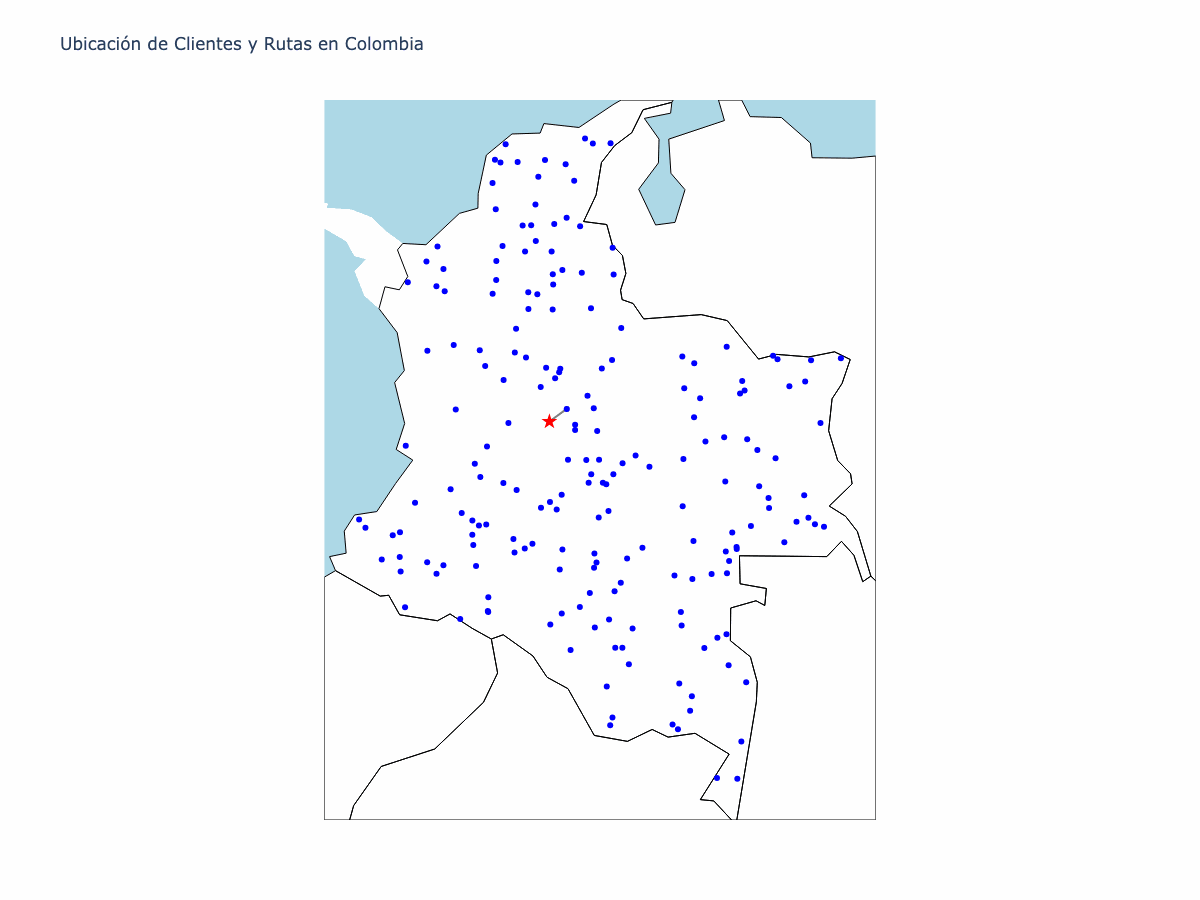

In [45]:
# ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

# . Mostrar la evolución de Optimizador
hacer_gif("Assets/NN/*.png", "Assets/NN/tour_nn.gif", ms_por_frame=100)
display(Image(filename='Assets/NN/tour_nn.gif'))

### CI

In [18]:
# ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

tour_ci, sols_ci, times_ci, valido_ci = tsp_cheapest_insertion(clientes, N, A, start=N[0])
print("Distancia total (CI):", round(tour_cost(tour_ci, A), 2))

visualizar(clientes, tour_ci, nombre_archivo="CI/1001")

resultados.append({
    "Método"    : "CI",
    "Distancia" : round(tour_cost(tour_ci, A), 2),
    "Tiempo (s)": times_ci[-1]
})

Distancia total (CI): 14022.43


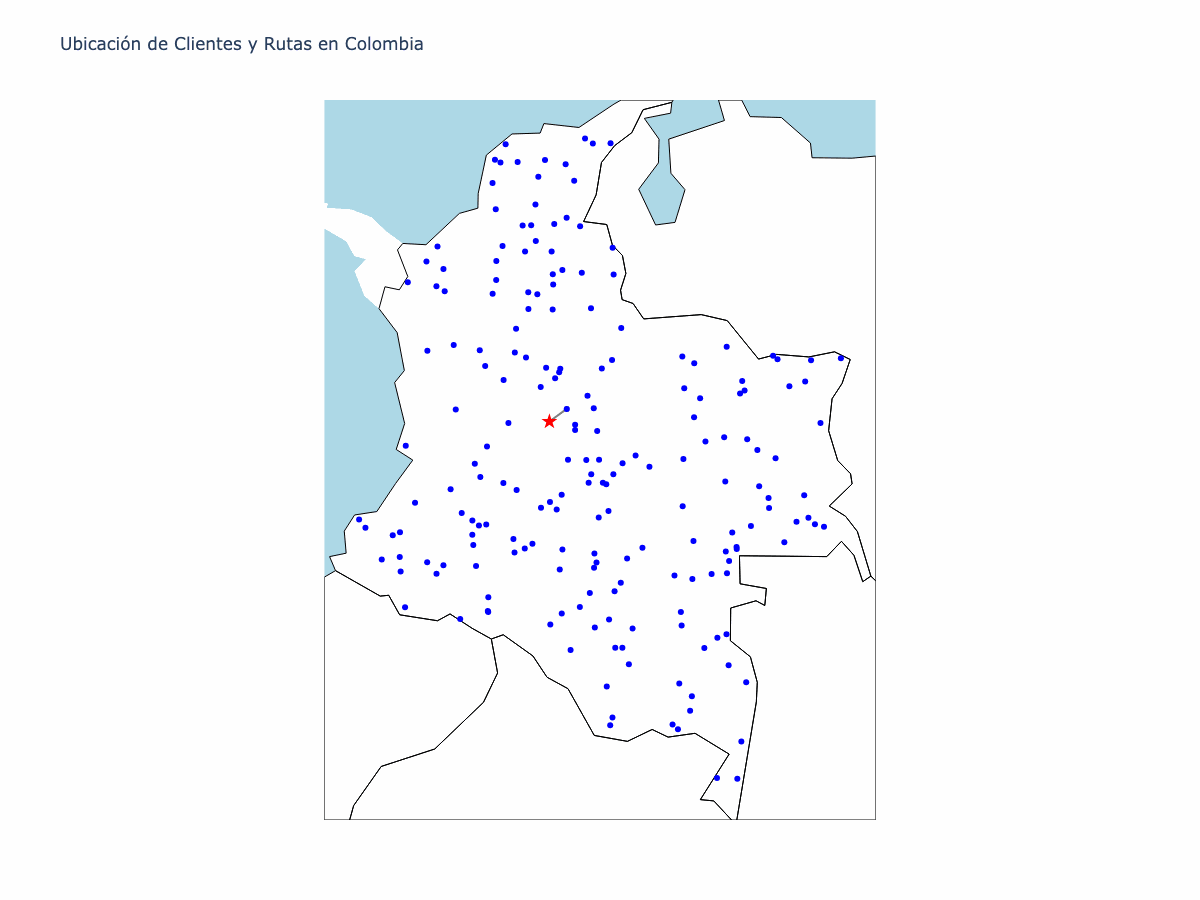

In [44]:
# ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

# . Mostrar la evolución de Optimizador
hacer_gif("Assets/CI/*.png", "Assets/CI/tour_ci.gif", ms_por_frame=100)
display(Image(filename='Assets/CI/tour_ci.gif'))

### 2OPT - NN

In [20]:
# ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

tour_2opt_nn, sols_2opt_nn, times_2opt_nn, valido_2opt_nn = tsp_2opt_atsp(clientes, tour_nn, A, name = "NN")
print("Distancia total (2OPT + NN):", round(tour_cost(tour_2opt_nn, A), 2))

visualizar(clientes, tour_2opt_nn, nombre_archivo="2OPT_NN/1001")

resultados.append({
    "Método"    : "2OPT + NN",
    "Distancia" : round(tour_cost(tour_2opt_nn, A), 2),
    "Tiempo (s)": times_2opt_nn[-1]
})

Distancia total (2OPT + NN): 12965.81


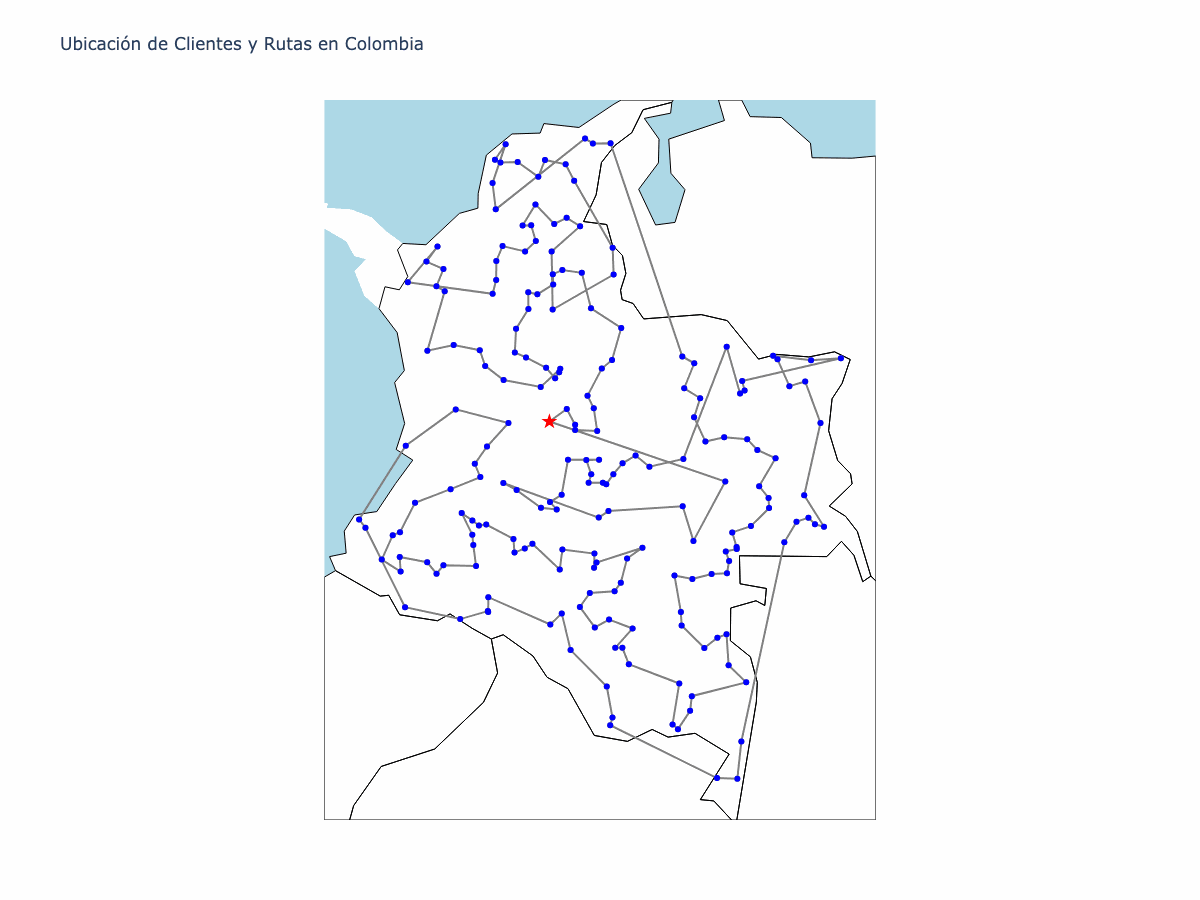

In [42]:
# ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

# . Mostrar la evolución de Optimizador
hacer_gif("Assets/2OPT_NN/*.png", "Assets/2OPT_NN/tour_2OPT_NN.gif", ms_por_frame=300)
display(Image(filename='Assets/2OPT_NN/tour_2OPT_NN.gif'))

### 2OPT - CI

In [22]:
# ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

tour_2opt_ci, sols_2opt_ci, times_2opt_ci, valido_2opt_ci = tsp_2opt_atsp(clientes, tour_ci, A, name = "CI")
print("Distancia total (2OPT + CI):", round(tour_cost(tour_2opt_ci, A), 2))

visualizar(clientes, tour_2opt_ci, nombre_archivo="2OPT_CI/1001")

resultados.append({
    "Método"    : "2OPT + CI",
    "Distancia" : round(tour_cost(tour_2opt_ci, A), 2),
    "Tiempo (s)": times_2opt_ci[-1]
})

Distancia total (2OPT + CI): 13007.54


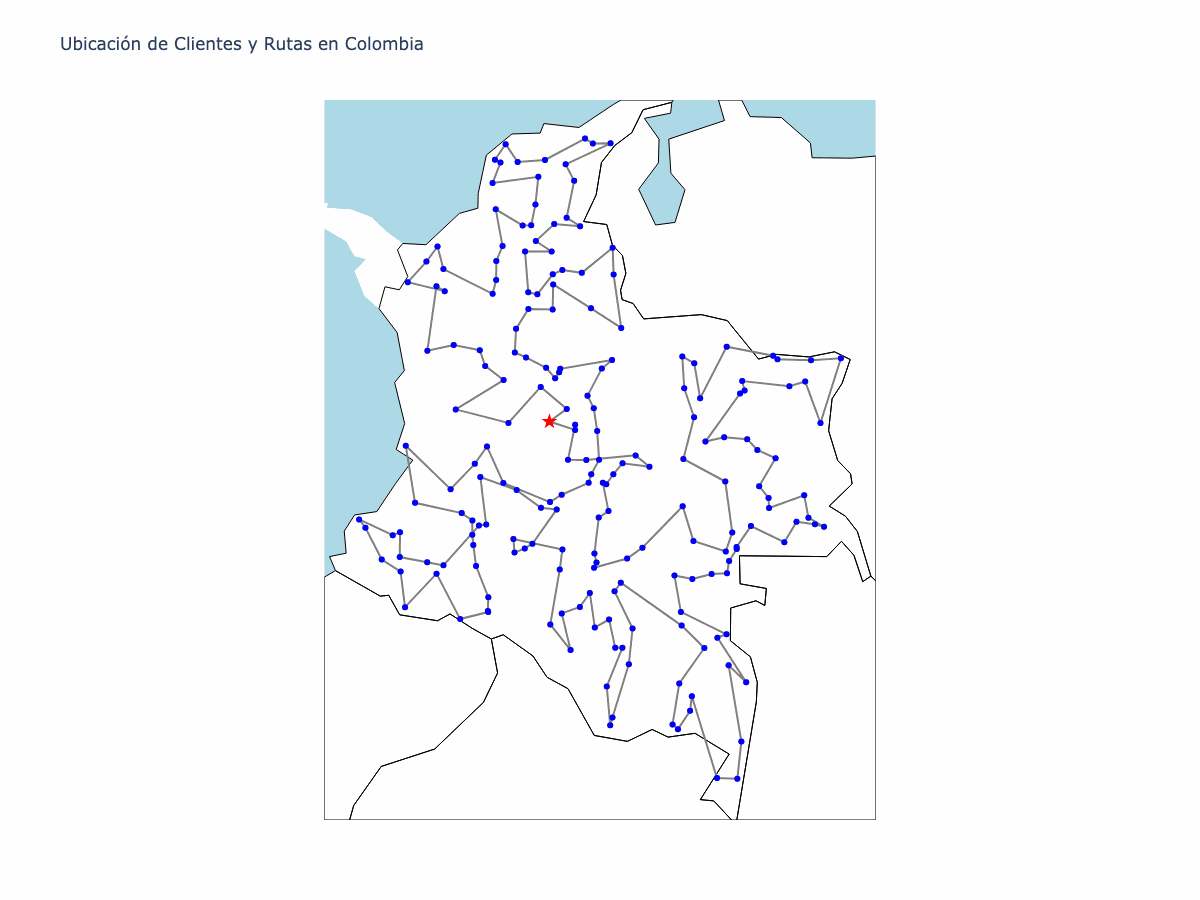

In [41]:
# ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

# . Mostrar la evolución de Optimizador
hacer_gif("Assets/2OPT_CI/*.png", "Assets/2OPT_CI/tour_2OPT_CI.gif", ms_por_frame=300)
display(Image(filename='Assets/2OPT_CI/tour_2OPT_CI.gif'))

## Resultados

In [24]:
import pandas as pd

# -- Crear DataFrame desde la lista de resultados --
df_resultados = pd.DataFrame(resultados)

# -- Establecer 'Método' como índice --
df_resultados.set_index("Método", inplace=True)

# -- Ordenar por empleos generados (de mayor a menor) --
df_resultados.sort_values("Distancia", ascending=True, inplace=True)

# -- Visualizar resultados ordenados --
df_resultados

,Distancia,Tiempo (s)
Método,,
LP,11773.89,110.060594
2OPT + NN,12965.81,0.000422
2OPT + CI,13007.54,0.000195
CI,14022.43,0.341625
NN,14552.66,0.020914


In [25]:
# -- Tomar la solución base de referencia (LP) --
base_lp = df_resultados.loc["LP"]

# -- Calcular el GAP porcentual relativo al método LP (excepto para Tiempo) --
gap_df = ((df_resultados - base_lp) / base_lp) * 100

# -- Reemplazar la columna de tiempo con "x veces LP" en lugar de porcentaje --
tiempo_ratio = (df_resultados["Tiempo (s)"] / base_lp["Tiempo (s)"]).round(4)

# -- Redondear GAPs a 3 decimales --
gap_df = gap_df.round(3)

# -- Renombrar columnas GAP --
gap_df.columns = [col + " GAP (%)" for col in gap_df.columns]

# -- Reemplazar columna de tiempo con "x veces LP" --
gap_df["Tiempo (s) (x veces LP)"] = tiempo_ratio

# -- Eliminar columna anterior de GAP de tiempo --
gap_df = gap_df.drop(columns=["Tiempo (s) GAP (%)"])

# -- Mostrar tabla --
gap_df

,Distancia GAP (%),Tiempo (s) (x veces LP)
Método,,
LP,0.000,1.0000
2OPT + NN,10.123,0.0000
2OPT + CI,10.478,0.0000
CI,19.098,0.0031
NN,23.601,0.0002


#### Aux

In [38]:
import plotly.graph_objects as go
import plotly.express as px

def plot_convergencia_multi(series, titulo="Time vs FO"):
    """
    series: lista de tuplas (nombre, times, sols, valido)
            ej: [("MIP", times_mip, sols_mip, valido_mip), ...]
    """
    fig = go.Figure()

    line_colors = ["black", "blue", "orange", "purple", "brown", "teal", "gray"]

    for idx, (nombre, times, sols, valido) in enumerate(series):
        colores = ['green' if v else 'red' for v in valido]
        fig.add_trace(go.Scatter(
            x=times,
            y=sols,
            mode='lines+markers',
            marker=dict(size=4, color=colores),
            line=dict(width=1.5, color=line_colors[idx % len(line_colors)]),
            name=nombre
        ))

    fig.update_layout(
        title=titulo,
        xaxis=dict(title="Time"),
        yaxis=dict(title="Función Objetivo", showgrid=False),
        plot_bgcolor="white",
        legend=dict(title="Heurística / Método")
    )

    fig.show()


In [27]:
import plotly.graph_objects as go

def plot_distancias_barras(df):
    """
    Muestra la métrica de distancia para cada método.
    df debe tener:
        - Índice: nombre de cada método
        - Columna 'Distancia'
    """
    metodos = df.index
    valores = df["Distancia"]

    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=metodos,
        y=valores,
        text=valores.round(2),
        textposition="outside",
        marker_color="#4caf50"
    ))

    fig.update_layout(
        title="Distancia total por método",
        xaxis_title="Método",
        yaxis_title="Distancia (km)",
        plot_bgcolor="white",
        paper_bgcolor="white"
    )

    fig.show()


In [28]:
import plotly.express as px

def plot_eficiencia(df):
    """
    Dispersión log‑log: eje X = Tiempo de ejecución (s),
                       eje Y = Distancia.
    Cada punto es un método con color propio y grid activado.
    """
    df_plot = df.reset_index().rename(columns={"index": "Método"})

    fig = px.scatter(
        df_plot,
        x="Tiempo (s)",
        y="Distancia",     # <--- CORREGIDO
        color="Método",
        size_max=15
    )

    fig.update_traces(
        marker=dict(size=12, line=dict(width=1, color="black"))
    )

    fig.update_xaxes(type="log",
                     showgrid=True, gridcolor="lightgray", zeroline=False)
    fig.update_yaxes(showgrid=True, gridcolor="lightgray", zeroline=False)

    fig.update_layout(
        title="Eficiencia: Distancia vs Tiempo",
        xaxis_title="Tiempo de ejecución (s)  [escala log]",
        yaxis_title="Distancia total",
        plot_bgcolor="white",
        paper_bgcolor="white",
        legend_title="Método",
    )
    fig.show()


In [29]:
import plotly.graph_objects as go

def plot_gaps(gap_df):
    """
    Muestra solo el GAP de distancia (%) en barras verticales.
    """
    col = "Distancia GAP (%)"
    metodos = gap_df.index
    valores = gap_df[col]

    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=metodos,
        y=valores,
        marker_color="#4caf50",
        text=[f"{v:.2f}%" for v in valores],
        textposition="outside",
        showlegend=False
    ))

    # Línea horizontal en y=0
    fig.add_shape(
        type="line",
        x0=-0.5, x1=len(metodos) - 0.5,
        y0=0, y1=0,
        xref="x", yref="y",
        line=dict(color="black", width=1)
    )

    fig.update_yaxes(title_text="%")
    fig.update_layout(
        plot_bgcolor="white",
        paper_bgcolor="white",
        title_text="GAP en distancia (%)",
        title_x=0.5,
    )
    fig.show()


In [30]:
import plotly.graph_objects as go

def plot_tiempo_relativo(gap_df, ordenar=True):
    """
    Barras horizontales: Tiempo relativo (× LP) para cada método.
    • LP en gris, otros en azul.
    • Etiqueta del valor a la derecha.
    • Si ordenar=True se listan de mayor a menor.
    """
    columna_tiempo = "Tiempo (s) (x veces LP)"  # columna en el nuevo df
    data = gap_df.sort_values(columna_tiempo, ascending=False) if ordenar else gap_df

    colores = ["#888888" if m == "LP" else "#2196f3" for m in data.index]
    max_val = data[columna_tiempo].max()
    limite_x = max_val * 1.2

    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=data[columna_tiempo],
        y=data.index,
        orientation="h",
        marker_color=colores,
        text=[f"{v:.4f}" for v in data[columna_tiempo]],
        textposition="outside"
    ))

    fig.update_layout(
        xaxis=dict(title="Tiempo relativo (× LP)", range=[0, limite_x]),
        title="Velocidad relativa a LP",
        plot_bgcolor="white",
        paper_bgcolor="white",
        showlegend=False
    )
    fig.show()


#### Comparar

In [31]:
plot_distancias_barras(df_resultados)
plot_eficiencia(df_resultados)

In [32]:
plot_gaps(gap_df)
plot_tiempo_relativo(gap_df)

In [39]:
series = [
    ("MIP",        times_mip,        sols_mip,        valido_mip),
    ("NN",         times_nn,         sols_nn,         valido_nn),
    ("CI",         times_ci,         sols_ci,         valido_ci),
    ("2opt_CI",    times_2opt_ci,    sols_2opt_ci,    valido_2opt_ci),
    ("2opt_NN",    times_2opt_nn,    sols_2opt_nn,    valido_2opt_nn),
]

plot_convergencia_multi(series)



> Los puntos rojos son soluciones no factibles, que los diferentes métodos fueron encontrando.